Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится) и посчитать метрики качества (roc auc, pr/rec/f1, logloss)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

from xgboost import XGBClassifier

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('/Users/macbook/Downloads/pop_failures.dat', delim_whitespace=' ')

In [4]:
df.outcome.value_counts()

1    494
0     46
Name: outcome, dtype: int64

In [5]:
X = df.drop('outcome', axis=1)
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [6]:
model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

[15:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [7]:
def evaluate_results(y_test, y_predict):
    
    f1 = f1_score(y_test, y_predict)
    roc = roc_auc_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict, average='binary')
    precision = precision_score(y_test, y_predict, average='binary')
    
    return f1, roc, precision, recall
    
f1score, roc_auc, precision, recall = evaluate_results(y_test, y_predict)

metrics_data = []
metrics_data.append((1, f1score, roc_auc, precision, recall))

In [8]:
modified_df = df.copy()
#get the indices of the positives samples
position_indexes = np.where(modified_df.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(position_indexes)

# leave just 25% of the positives marked
position_sample_len_10 = int(np.ceil(0.10 * len(position_indexes)))
position_sample_len_25 = int(np.ceil(0.25 * len(position_indexes)))
position_sample_len_30 = int(np.ceil(0.30 * len(position_indexes)))
position_sample_len_40 = int(np.ceil(0.40 * len(position_indexes)))
position_sample_len_50 = int(np.ceil(0.50 * len(position_indexes)))

print(f'Using {position_sample_len_10}/{len(position_indexes)} as positives and unlabeling the rest')
print(f'Using {position_sample_len_25}/{len(position_indexes)} as positives and unlabeling the rest')
print(f'Using {position_sample_len_30}/{len(position_indexes)} as positives and unlabeling the rest')
print(f'Using {position_sample_len_40}/{len(position_indexes)} as positives and unlabeling the rest')
print(f'Using {position_sample_len_50}/{len(position_indexes)} as positives and unlabeling the rest')

position_sample_10 = position_indexes[:position_sample_len_10]
position_sample_25 = position_indexes[:position_sample_len_25]
position_sample_30 = position_indexes[:position_sample_len_30]
position_sample_40 = position_indexes[:position_sample_len_40]
position_sample_50 = position_indexes[:position_sample_len_50]

Using 50/494 as positives and unlabeling the rest
Using 124/494 as positives and unlabeling the rest
Using 149/494 as positives and unlabeling the rest
Using 198/494 as positives and unlabeling the rest
Using 247/494 as positives and unlabeling the rest


In [9]:
def split_data_and_fit(data, position_sample, proportion_class_1):
    
    modified_data = data.copy()
    
    modified_data['test_outcome'] = -1
    modified_data.loc[position_sample,'test_outcome'] = 1

    X_data = modified_data.iloc[:,:-2].values # just the X 
    y_labeled = modified_data.iloc[:,-1].values # new class (just the P & U)
    y_positive = modified_data.iloc[:,-2].values # original class

    mod_data = modified_data.sample(frac=1)
    neg_sample = modified_data[modified_data['test_outcome']==-1][:len(modified_data[modified_data['test_outcome']==1])]
    sample_test = modified_data[modified_data['test_outcome']==-1][len(modified_data[modified_data['test_outcome']==1]):]
    pos_sample = modified_data[modified_data['test_outcome']==1]

    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    model = XGBClassifier()

    model.fit(sample_train.iloc[:,:-2].values, 
              sample_train.iloc[:,-2].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)

    f1score, roc_auc, precision, recall = evaluate_results(sample_test.iloc[:,-2].values, y_predict)

    metrics_data.append((proportion_class_1, f1score, roc_auc, precision, recall))

In [10]:
split_data_and_fit(modified_df, position_sample_10, 0.10)
split_data_and_fit(modified_df, position_sample_25, 0.25)
split_data_and_fit(modified_df, position_sample_30, 0.30)
split_data_and_fit(modified_df, position_sample_40, 0.40)
split_data_and_fit(modified_df, position_sample_50, 0.50)

/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/xgboost/s

[15:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [11]:
metrics_data = pd.DataFrame(metrics_data, columns=['proportion_class_1', 'f1_score', 'roc_auc_score', 'precision', 'recall'])

In [15]:
metrics_data = metrics_data.sort_values('proportion_class_1', ascending=True)
metrics_data

,proportion_class_1,f1_score,roc_auc_score,precision,recall
1,0.10,0.948626,0.498744,0.904328,0.997487
2,0.25,0.965138,0.676677,0.935943,0.996212
3,0.30,0.960352,0.625000,0.923729,1.000000
4,0.40,0.958491,0.683594,0.927007,0.992188
5,0.50,0.962963,0.785714,0.928571,1.000000
0,1.00,0.976744,0.782336,0.960784,0.993243


In [20]:
metrics_data.columns.tolist()

['proportion_class_1', 'f1_score', 'roc_auc_score', 'precision', 'recall']

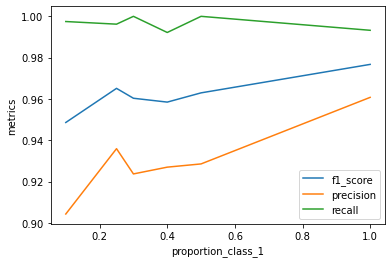

In [25]:
plt.plot(metrics_data['proportion_class_1'], metrics_data['f1_score'], label='f1_score')
# plt.plot(metrics_data['proportion_class_1'], metrics_data['roc_auc_score'], label='roc_auc_score')
plt.plot(metrics_data['proportion_class_1'], metrics_data['precision'], label='precision')
plt.plot(metrics_data['proportion_class_1'], metrics_data['recall'], label='recall')
plt.xlabel('proportion_class_1')
plt.ylabel('metrics')
plt.legend()
plt.show()